In [1]:
%load_ext autoreload

In [2]:
import base64
import io
import pickle
import requests
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
import os
# os.environ["OPENAI_API_KEY"]="sk-xxxxxx"


In [3]:
from torchvision import transforms
# from ..api.language_model import GPT4V
# from ..api.segmentors import SAM
from api.language_model import GPT4V
from api.segmentors import SAM
from api.detectors import OWLViT
# from language_model import GPT4V
# from segmentors import SAM
from agent.agents import SegVLM, DetVLM, DetLLM

In [4]:
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")


prompt="""task: Describe the image.
          """

action_space = """
 - pick(item)
 - place(item, orientation)
 - open(item)
"""



In [5]:
# Segmentation + VLM
gpt4v = GPT4V()
sam = SAM()
agent = SegVLM(segmentor=sam, vlm=gpt4v, action_space=action_space)

result = agent.work(prompt, image)
print(result)


AttributeError: 'SegVLM' object has no attribute 'work'

In [ ]:
# Detection + VLM
gpt4v = GPT4V()
owl_vit = OWLViT()
agent = DetVLM(detector=owl_vit, vlm=gpt4v, action_space=action_space)

result = agent.work(prompt, image)
print(result)


The image displays a scenic urban landscape. In the foreground, there is lush greenery with a variety of trees, indicating a park or a garden area. Just beyond the greenery, we can see buildings of various architectural styles. The most prominent one is a multi-storied building with a red-tiled roof and a green facade, which could be an institutional or commercial building. In the background, there are more high-rise buildings, one with reflective glass and a unique curved design, hinting at a modern commercial or office building. We also see a construction crane, suggesting ongoing development in the area. The weather appears to be overcast or cloudy, with no direct sunlight visible in the image.


In [ ]:
# Detection + LLM
gpt4v = GPT4V()
owl_vit = OWLViT()
agent = SegVLM(segmentor=sam, vlm=gpt4v, action_space=action_space)

result = agent.work(prompt)
print(result)


In [ ]:
owl_vit.detect_objects(image=image, text_queries=["roof"], bbox_conf_threshold=0.3)

[{'score': 0.3141017258167267,
  'box': [0.212062269449234,
   0.3956533372402191,
   0.29010745882987976,
   0.08735490590333939],
  'box_name': 'roof',
  'objectness': 0.09425540268421173},
 {'score': 0.32486796379089355,
  'box': [0.9511756300926208,
   0.45574820041656494,
   0.08415518701076508,
   0.05109325423836708],
  'box_name': 'roof',
  'objectness': 0.12236481159925461},
 {'score': 0.43618306517601013,
  'box': [0.7464314699172974,
   0.3669348955154419,
   0.21871830523014069,
   0.0474105142056942],
  'box_name': 'roof',
  'objectness': 0.06783194839954376},
 {'score': 0.5705604553222656,
  'box': [0.1794598400592804,
   0.4030904173851013,
   0.35850971937179565,
   0.11342517286539078],
  'box_name': 'roof',
  'objectness': 0.14967934787273407}]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


# def show_masks_on_image(raw_image, masks, scores):
#     if len(masks.shape) == 4:
#       masks = masks.squeeze()
#     if scores.shape[0] == 1:
#       scores = scores.squeeze()

#     nb_predictions = scores.shape[-1]
#     fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

#     for i, (mask, score) in enumerate(zip(masks, scores)):
#       mask = mask.cpu().detach()
#       axes[i].imshow(np.array(raw_image))
#       show_mask(mask, axes[i])
#       axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
#       axes[i].axis("off")
#     plt.show()

def show_masks_on_image(raw_image, masks, scores):
    fig, axes = plt.subplots(1, 4, figsize=(15, 15))
    for i,mask in enumerate(masks):
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
    plt.show()

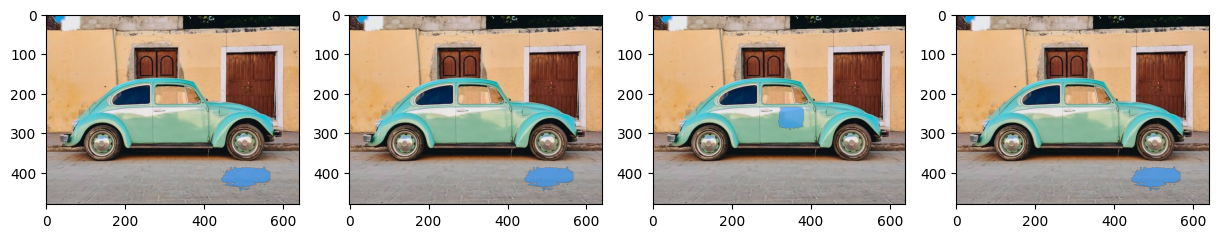

In [ ]:
sam = SAM()

# masks = sam.segment_auto_mask(image)
# masks = sam.segment_mask_by_point_set(image, points=np.array([[[0.5, 0.5],[0.6, 0.6]], [[0.7, 0.8], [0.9, 0.4]]]), point_labels=np.array([[1,1],[1,1]]))
masks = sam.segment_mask_by_bboxes(image, bboxes=[[[0.7, 0.8, 0.9, 0.9]], [[0.7, 0.8, 0.9, 0.9]], [[0.5, 0.5, 0.6, 0.6]], [[0.7, 0.8, 0.9, 0.9]]])
show_masks_on_image(image, [mask["segmentation"] for mask in masks], scores = np.array([1,2,3,4]))

In [ ]:
masks[0]['segmentation'].shape

(480, 640)